In [1]:
import pandas as pd

#Read the data from the csv file
data = pd.read_csv('diabetes.csv')

# #Display the data out after dropping som columns
display(data)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<function matplotlib.pyplot.show(close=None, block=None)>

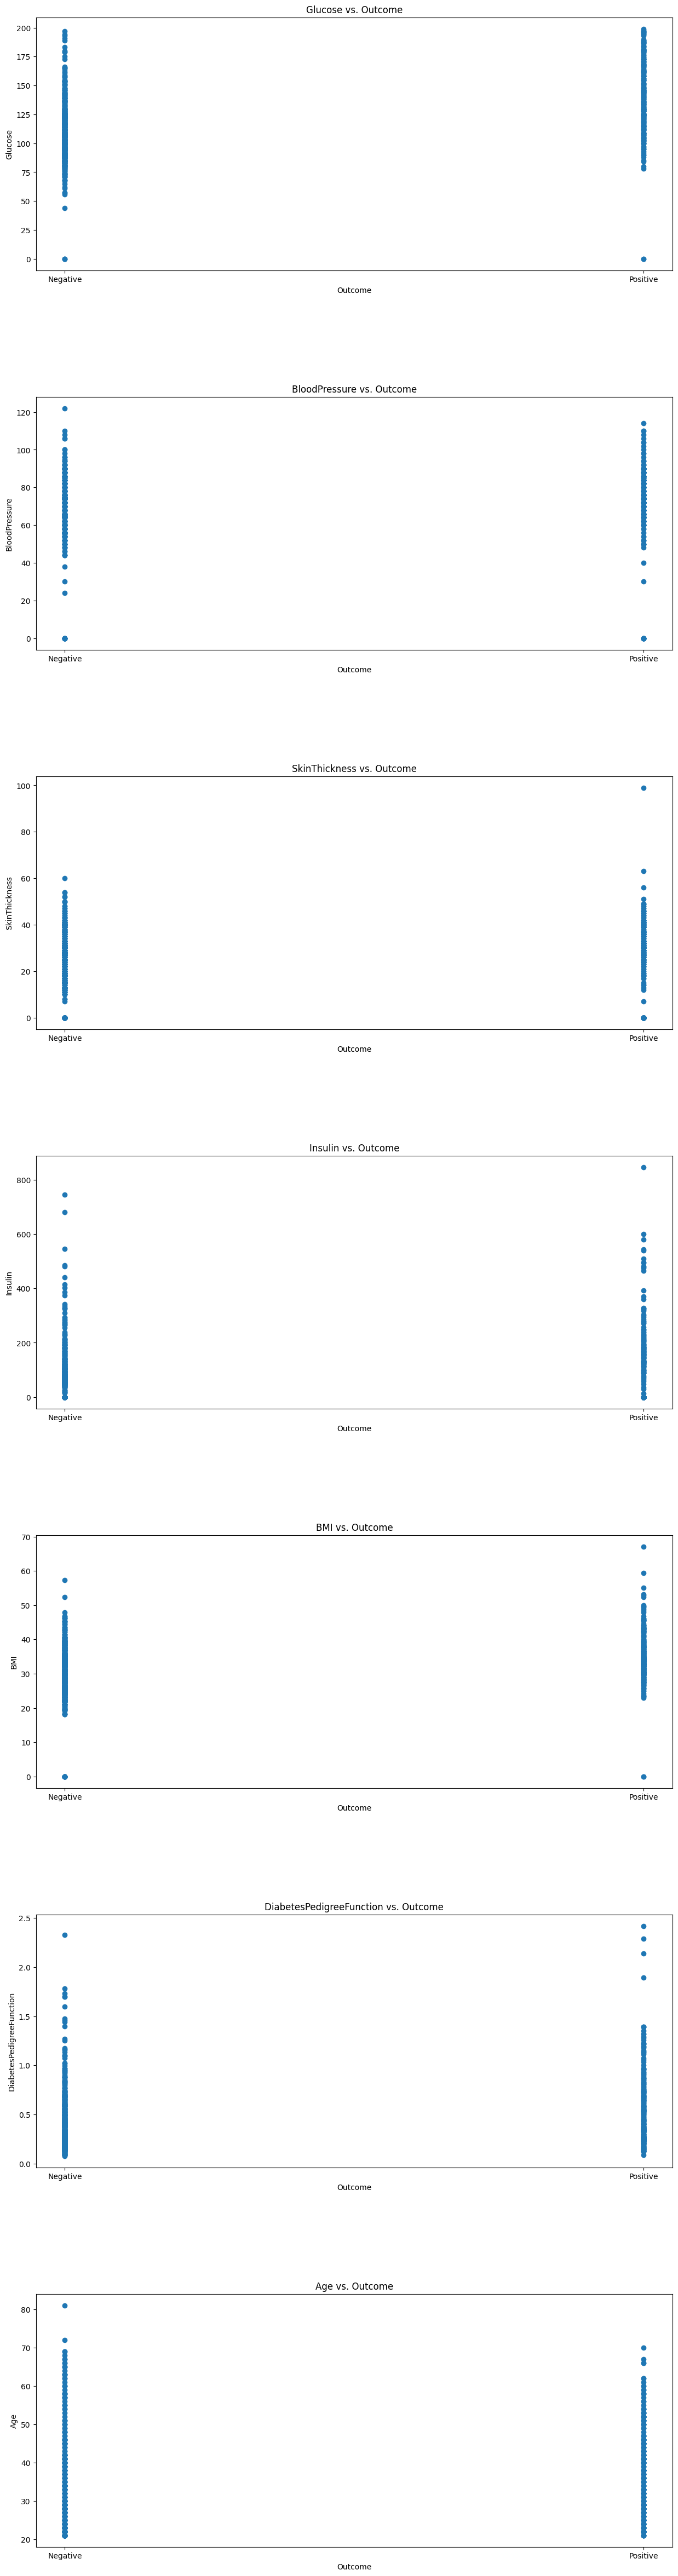

In [2]:
import matplotlib.pyplot as plt

features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
x = data['Outcome']

feature_length = len(features)

fig, axes = plt.subplots(feature_length, 1, figsize=(15,60))

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(x, data[feature], label=feature, linestyle='', marker='o')
    ax.set_title(f'{feature} vs. Outcome')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(f'{feature}')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])

plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
plt.show

In [3]:
#drop the target features, in this model, our target will be the outcome
target_column = ['Outcome']
X = data.drop(target_column, axis = 1)
y = data[target_column]

print('Below is the Features column:\n')
print(X)
print('Below is the Target column:\n')
print(y)

Below is the Features column:

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1     

In [4]:
from sklearn.model_selection import train_test_split

#Start to split the data for training and testing
random = 88

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random)

#Just print out the shape to make sure they are the same
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (537, 8) (537, 1)
Testing data shape: (231, 8) (231, 1)


In [5]:
from sklearn.linear_model import LogisticRegression

#Use Decision Tree Regressor for Model Training
logistic_regressor = LogisticRegression(random_state = random, max_iter = 1000)
logistic_regressor.fit(X_train, y_train.values.ravel())

#Start to predict the data
y_pred_logistic_regression = logistic_regressor.predict(X_test)

In [6]:
from sklearn.ensemble import RandomForestClassifier

#User Random Forest Classifier for Model Training
random_forest = RandomForestClassifier(n_estimators = 150, random_state = random)
random_forest.fit(X_train, y_train.values.ravel())

#Start to predict the data
y_pred_random_forest = random_forest.predict(X_test)

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score

print('This score is from Logistic Regression')
mse = mean_squared_error(y_test, y_pred_logistic_regression)
print(f'The Mean Squared Error is : {mse:.2f}')
mae = mean_absolute_error(y_test, y_pred_logistic_regression)
print(f'The Mean Absolute Error is {mae:.2f}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_logistic_regression))
print(f'The Root mean squared error is {rmse:.2f}')
f1 = f1_score(y_test, y_pred_logistic_regression)
print(f'The F1 Score is: {f1:.2f}')


print('\nThis score is from Random Forest Classifier')
mse = mean_squared_error(y_test, y_pred_random_forest)
print(f'The Mean Squared Error is : {mse:.2f}')
mae = mean_absolute_error(y_test, y_pred_random_forest)
print(f'The Mean Absolute Error is {mae:.2f}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_random_forest))
print(f'The Root mean squared error is {rmse:.2f}')
f1 = f1_score(y_test, y_pred_random_forest)
print(f'The F1 Score is: {f1:.2f}')


This score is from Logistic Regression
The Mean Squared Error is : 0.22
The Mean Absolute Error is 0.22
The Root mean squared error is 0.47
The F1 Score is: 0.62

This score is from Random Forest Classifier
The Mean Squared Error is : 0.20
The Mean Absolute Error is 0.20
The Root mean squared error is 0.45
The F1 Score is: 0.67


In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score_logistic_regression = cross_val_score(logistic_regressor, X, y.values.ravel(), cv = 5, scoring = 'accuracy')
cross_val_score_random_forest = cross_val_score(random_forest, X, y.values.ravel(), cv = 5, scoring = 'accuracy')

print(f'The Mean Logistic Regression Cross Validation Score is : {cross_val_score_logistic_regression}')
print(f'The Mean Random Forest Classifier Cross Validation Score is {cross_val_score_random_forest}')

The Mean Logistic Regression Cross Validation Score is : [0.77272727 0.74675325 0.75324675 0.81045752 0.77777778]
The Mean Random Forest Classifier Cross Validation Score is [0.76623377 0.72077922 0.77922078 0.8496732  0.75163399]


In [9]:
import joblib

#Exporting model
# model_filename = 'trained_model'
# joblib.dump('Diabetes Predict', model_filename)

In [10]:
#Sample data for model testing
input_data = [[0, 128, 90, 29, 178, 35, 0.54, 40]]

def getResult(result):
    if(result == 1):
        return 'Positive'
    else:
        return 'Negative'
        
lr_predict = logistic_regressor.predict(input_data)
rf_predict = random_forest.predict(input_data)

print(f'The prediction from Logistic Regression is {getResult(lr_predict)}')
print(f'The prediction from Random Forest is {getResult(rf_predict)}')

    

The prediction from Logistic Regression is Negative
The prediction from Random Forest is Positive


C:\Users\Steven\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Steven\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
